In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
%matplotlib qt

In [2]:
df = pd.read_csv('11077.csv',index_col=[0],parse_dates=[0])

In [3]:
df.head()

,Y,Unnamed: 2,Unnamed: 3,Unnamed: 4
DS,,,,
2013-06-29,13.0,NaN,NaN,NaN
2013-06-02,5.0,NaN,NaN,NaN
2013-06-04,80.0,NaN,NaN,NaN
2013-06-15,0.0,NaN,NaN,NaN
2013-06-16,120.0,NaN,NaN,NaN


In [4]:
df.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis = 1, inplace = True)

In [5]:
df.head()

,Y
DS,
2013-06-29,13.0
2013-06-02,5.0
2013-06-04,80.0
2013-06-15,0.0
2013-06-16,120.0


In [6]:
df.isnull().sum()

Delay    3
dtype: int64

In [7]:
mean = df['Delay'].mean()
df.fillna(mean,inplace=True)

In [8]:
df.isnull().sum()

Delay    0
dtype: int64

In [9]:
type(df)

pandas.core.frame.DataFrame

In [10]:
series_value = df.values

In [11]:
type(series_value)

numpy.ndarray

In [12]:
df.size

1775

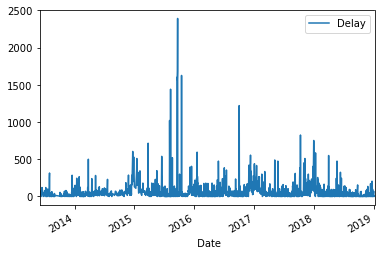

In [13]:
df.plot()

In [14]:
df_mean = df.rolling(window=12).mean()

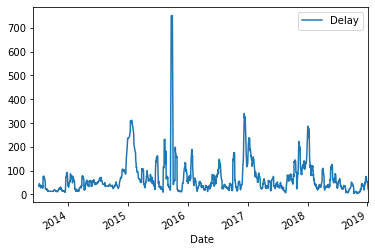

In [15]:
df_mean.plot()

In [16]:
df_std = df.rolling(window=12).std()

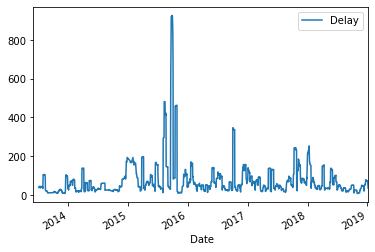

In [17]:
df_std.plot()

In [18]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, Delay):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[Delay].rolling(window = 12, center = False).mean()
    rolstd = df[Delay].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[Delay], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(Delay))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[Delay], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

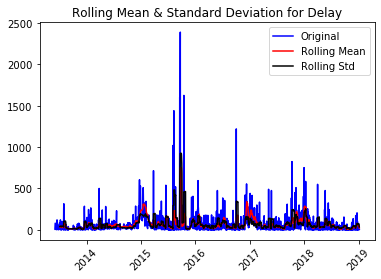

Results of Dickey-Fuller Test:
Test Statistic                -6.421073e+00
p-value                        1.790979e-08
# Lags Used                    2.100000e+01
Number of Observations Used    1.753000e+03
Critical Value (1%)           -3.434086e+00
Critical Value (5%)           -2.863190e+00
Critical Value (10%)          -2.567648e+00
dtype: float64


In [19]:
test_stationarity(df, Delay = 'Delay')

In [20]:
# look at data
display(df.head())

# look a shape of data
display(df.shape)

# look at data types. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].dtypes)

# see if any columns have nulls. Ideally look at all rows. Only look at first five here for minimal output.
display(df.iloc[:5,:5].isnull().any())

# display descriptive statistics
display(df.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

,Delay
Date,
2013-06-29,13.0
2013-06-02,5.0
2013-06-04,80.0
2013-06-15,0.0
2013-06-16,120.0


(1775, 1)

Delay    float64
dtype: object

Delay    False
dtype: bool

,Delay
count,1775.000000
mean,68.357223
std,141.800233
min,0.000000
25%,10.000000
50%,30.000000
75%,70.000000
85%,115.000000
95%,240.000000
99%,541.860000


In [21]:
def plot_transformed_data(df, Delay, Delay_transform):
  """
  Plot transformed and original time series data
  """
  # Plot time series data
  f, ax = plt.subploDelay(1,1)
  ax.plot(df[Delay])
  ax.plot(df[Delay_transform], color = 'red')

  # Add title
  ax.set_title('%s and %s time-series graph' %(Delay, Delay_transform))

  # Rotate x-labels
  ax.tick_params(axis = 'x', rotation = 45)

  # Add legend
  ax.legend([Delay, Delay_transform])
  
  plt.show()
  plt.close()
  
  return

In [22]:
# Transformation - log Delay
df['Delay_log'] = df['Delay'].apply(lambda x: np.log(x))

# Transformation - 7-day moving averages of log Delay
df['Delay_log_moving_avg'] = df['Delay_log'].rolling(window = 7,
                                                               center = False).mean()

# Transformation - 7-day moving average Delay
df['Delay_moving_avg'] = df['Delay'].rolling(window = 7,
                                                       center = False).mean()

# Transformation - Difference between logged Delay and first-order difference logged Delay
# df['Delay_log_diff'] = df['Delay_log'] - df['Delay_log'].shift()
df['Delay_log_diff'] = df['Delay_log'].diff()

# Transformation - Difference between Delay and moving average Delay
df['Delay_moving_avg_diff'] = df['Delay'] - df['Delay_moving_avg']

# Transformation - Difference between logged Delay and logged moving average Delay
df['Delay_log_moving_avg_diff'] = df['Delay_log'] - df['Delay_log_moving_avg']

# Transformation - Difference between logged Delay and logged moving average Delay
df_transform = df.dropna()

# Transformation - Logged exponentially weighted moving averages (EWMA) Delay
df_transform['Delay_log_ewma'] = df_transform['Delay_log'].ewm(halflife = 7,
                                                                         ignore_na = False,
                                                                         min_periods = 0,
                                                                         adjust = True).mean()

# Transformation - Difference between logged Delay and logged EWMA Delay
df_transform['Delay_log_ewma_diff'] = df_transform['Delay_log'] - df_transform['Delay_log_ewma']

# Display data
display(df_transform.head())

# Plot data
plot_transformed_data(df = df, 
                      Delay = 'Delay', 
                      Delay_transform = 'Delay_log')
# Plot data
plot_transformed_data(df = df, 
                      Delay = 'Delay_log', 
                      Delay_transform = 'Delay_log_moving_avg')

# Plot data
plot_transformed_data(df = df_transform, 
                      Delay = 'Delay', 
                      Delay_transform = 'Delay_moving_avg')

# Plot data
plot_transformed_data(df = df_transform, 
                      Delay = 'Delay_log', 
                      Delay_transform = 'Delay_log_diff')

# Plot data
plot_transformed_data(df = df_transform, 
                      Delay = 'Delay', 
                      Delay_transform = 'Delay_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_transform, 
                      Delay = 'Delay_log', 
                      Delay_transform = 'Delay_log_moving_avg_diff')

# Plot data
plot_transformed_data(df = df_transform, 
                      Delay = 'Delay_log', 
                      Delay_transform = 'Delay_log_ewma')

# Plot data
plot_transformed_data(df = df_transform, 
                      Delay = 'Delay_log', 
                      Delay_transform = 'Delay_log_ewma_diff')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  Delay = 'Delay_log')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  Delay = 'Delay_moving_avg')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  Delay = 'Delay_log_moving_avg')

# Perform stationarity test
test_stationarity(df = df_transform,
                  Delay = 'Delay_log_diff')

# Perform stationarity test
test_stationarity(df = df_transform,
                  Delay = 'Delay_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_transform,
                  Delay = 'Delay_log_moving_avg_diff')

# Perform stationarity test
test_stationarity(df = df_transform, 
                  Delay = 'Delay_log_ewma')

# Perform stationarity test
test_stationarity(df = df_transform,
                  Delay = 'Delay_log_ewma_diff')

C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\pandas\core\algorithms.py:1819: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]
C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Delay,Delay_log,Delay_log_moving_avg,Delay_moving_avg,Delay_log_diff,Delay_moving_avg_diff,Delay_log_moving_avg_diff,Delay_log_ewma,Delay_log_ewma_diff
Date,,,,,,,,,
2013-08-21,15.0,2.708050,3.313611,32.142857,0.000000,-17.142857,-0.605561,2.708050,0.000000
2013-10-28,15.0,2.708050,2.614225,15.714286,-0.847298,-0.714286,0.093826,2.708050,0.000000
2013-10-29,10.0,2.302585,2.614225,15.714286,-0.405465,-5.714286,-0.311639,2.559313,-0.256728
2013-10-30,15.0,2.708050,2.614225,15.714286,0.405465,-0.714286,0.093826,2.602189,0.105861
2013-10-31,70.0,4.248495,2.834288,23.571429,1.540445,46.428571,1.414207,2.999655,1.248841


AttributeError: module 'matplotlib.pyplot' has no attribute 'subploDelay'

In [23]:
def plot_decomposition(df, Delay, trend, seasonal, residual):
  """
  Plot time series data
  """
  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[Delay], label = 'Original')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  # Show graph
  plt.suptitle('Trend, Seasonal, and Residual Decomposition of %s' %(Delay), 
               x = 0.5, 
               y = 1.05, 
               fontsize = 18)
  plt.show()
  plt.close()
  
  return

C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\pandas\core\indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


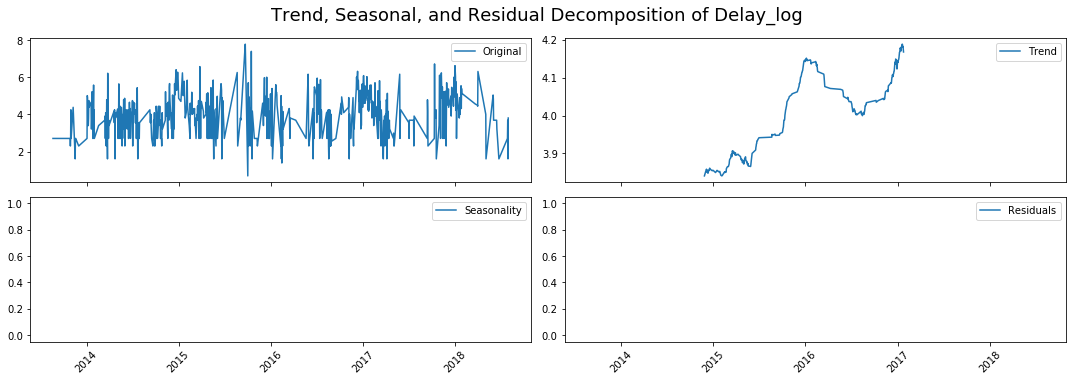

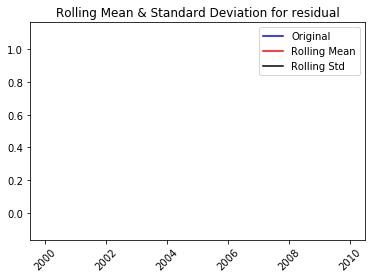

Results of Dickey-Fuller Test:


ValueError: sample size is too short to use selected regression component

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_transform['Delay_log'], freq = 365)

df_transform.loc[:,'trend'] = decomposition.trend
df_transform.loc[:,'seasonal'] = decomposition.seasonal
df_transform.loc[:,'residual'] = decomposition.resid

plot_decomposition(df = df_transform, 
                   Delay = 'Delay_log', 
                   trend = 'trend',
                   seasonal = 'seasonal', 
                   residual = 'residual')

test_stationarity(df = df_transform.dropna(), Delay = 'residual')

In [25]:
def plot_acf_pacf(df, Delay):
  """
  Plot auto-correlation function (ACF) and partial auto-correlation (PACF) plots
  """
  f, (ax1, ax2) = plt.subplots(1,2, figsize = (10, 5)) 

  #Plot ACF: 

  ax1.plot(lag_acf)
  ax1.axhline(y=0,linestyle='--',color='gray')
  ax1.axhline(y=-1.96/np.sqrt(len(df[Delay])),linestyle='--',color='gray')
  ax1.axhline(y=1.96/np.sqrt(len(df[Delay])),linestyle='--',color='gray')
  ax1.set_title('Autocorrelation Function for %s' %(Delay))

  #Plot PACF:
  ax2.plot(lag_pacf)
  ax2.axhline(y=0,linestyle='--',color='gray')
  ax2.axhline(y=-1.96/np.sqrt(len(df[Delay])),linestyle='--',color='gray')
  ax2.axhline(y=1.96/np.sqrt(len(df[Delay])),linestyle='--',color='gray')
  ax2.set_title('Partial Autocorrelation Function for %s' %(Delay))
  
  plt.tight_layout()
  plt.show()
  plt.close()
  
  return

C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


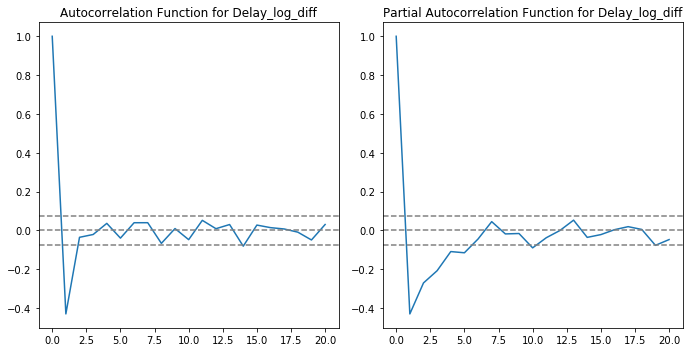

In [26]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

# determine ACF and PACF
lag_acf = acf(np.array(df_transform['Delay_log_diff']), nlags = 20)
lag_pacf = pacf(np.array(df_transform['Delay_log_diff']), nlags = 20)

# plot ACF and PACF
plot_acf_pacf(df = df_transform, Delay = 'Delay_log_diff')

In [27]:
def run_arima_model(df, Delay, p, d, q):
  """
  Run ARIMA model
  """
  from statsmodels.tsa.arima_model import ARIMA

  # fit ARIMA model on time series
  model = ARIMA(df[Delay], order=(p, d, q))  
  results_ = model.fit(disp=-1)  
  
  # get lengths correct to calculate RSS
  len_results = len(results_.fittedvalues)
  ts_modified = df[Delay][-len_results:]
  
  # calculate root mean square error (RMSE) and residual sum of squares (RSS)
  rss = sum((results_.fittedvalues - ts_modified)**2)
  rmse = np.sqrt(rss / len(df[Delay]))
  
  # plot fit
  plt.plot(df[Delay])
  plt.plot(results_.fittedvalues, color = 'red')
  plt.title('For ARIMA model (%i, %i, %i) for Delay %s, RSS: %.4f, RMSE: %.4f' %(p, d, q, Delay, rss, rmse))
  
  plt.show()
  plt.close()
  
  return results_

C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


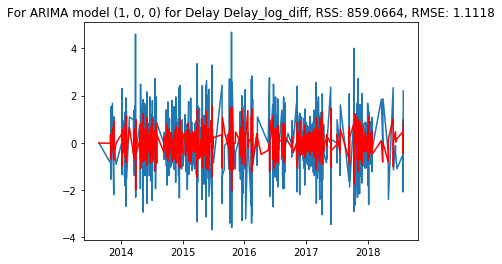

C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


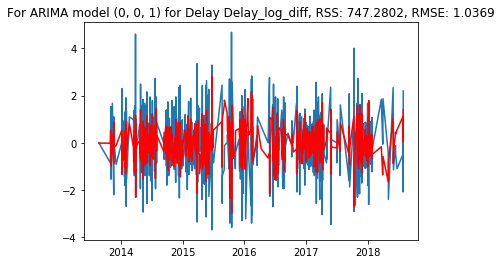

C:\Users\rames\Anaconda3\envs\tensor\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


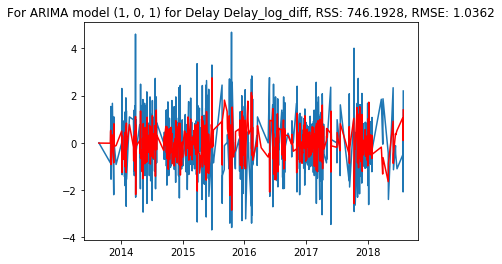

In [28]:
# Note: I do the differencing in the transformation of the data 'ts_log_diff'
# AR model with 1st order differencing - ARIMA (1,0,0)
model_AR = run_arima_model(df = df_transform, 
                           Delay = 'Delay_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 0)

# MA model with 1st order differencing - ARIMA (0,0,1)
model_MA = run_arima_model(df = df_transform, 
                           Delay = 'Delay_log_diff', 
                           p = 0, 
                           d = 0, 
                           q = 1)

# ARMA model with 1st order differencing - ARIMA (1,0,1)
model_MA = run_arima_model(df = df_transform, 
                           Delay = 'Delay_log_diff', 
                           p = 1, 
                           d = 0, 
                           q = 1)

In [1]:
from fbprophet import Prophet
import datetime
from datetime import datetime

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [15]:
pjme = pd.read_csv('11077.csv',index_col=[0],parse_dates=[0])
pjme.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis = 1, inplace = True)

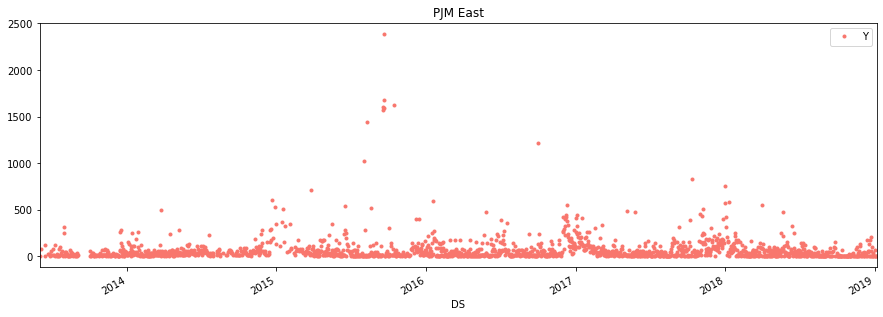

In [16]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')
plt.show()

In [17]:
split_date = '14-Dec-2017'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

In [18]:
pjme_train.head()

,Y
DS,
2013-06-29,13.0
2013-06-02,5.0
2013-06-04,80.0
2013-06-15,0.0
2013-06-16,120.0


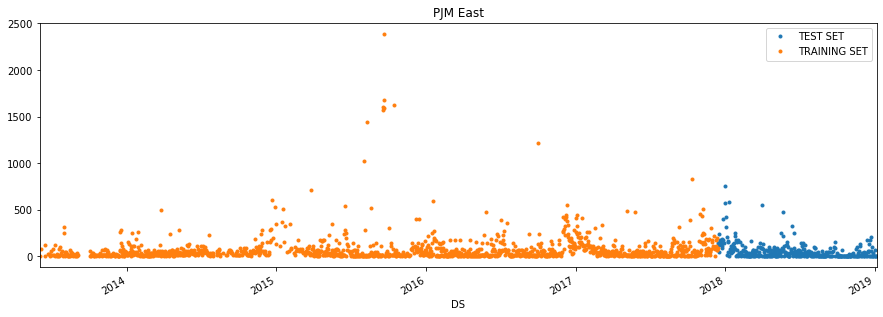

In [20]:
# Plot train and test so you can see where we have split
pjme_test \
    .rename(columns={'Y': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Y': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

In [22]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'DS':'ds',
                     'Y':'y'}).head()

,ds,y
0,2013-06-29,13.0
1,2013-06-02,5.0
2,2013-06-04,80.0
3,2013-06-15,0.0
4,2013-06-16,120.0


In [58]:
pjme_train.rename(index = {"Date":"ds"},inplace=True)

In [13]:
pjme_train.head()

,y
ds,
2013-06-29,13.0
2013-06-02,5.0
2013-06-04,80.0
2013-06-15,0.0
2013-06-16,120.0


In [23]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'DS':'ds',
                               'Y':'y'}))         

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'DS':'ds'}))

In [25]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-12-15,72.802454,-53.996744,331.013512,72.802454,72.802454,71.421629,71.421629,71.421629,2.841573,2.841573,2.841573,68.580056,68.580056,68.580056,0.0,0.0,0.0,144.224083
1,2017-12-16,72.789139,-43.954571,312.228548,72.789139,72.789139,61.688573,61.688573,61.688573,-4.783593,-4.783593,-4.783593,66.472166,66.472166,66.472166,0.0,0.0,0.0,134.477712
2,2017-12-17,72.775824,-54.558434,320.049293,72.775824,72.775824,59.667721,59.667721,59.667721,-4.419641,-4.419641,-4.419641,64.087362,64.087362,64.087362,0.0,0.0,0.0,132.443545
3,2017-12-18,72.762509,-39.342843,321.777149,72.762509,72.762509,68.016736,68.016736,68.016736,6.506497,6.506497,6.506497,61.510239,61.510239,61.510239,0.0,0.0,0.0,140.779245
4,2017-12-19,72.749194,-30.309959,335.674008,72.749194,72.749194,76.525076,76.525076,76.525076,17.697695,17.697695,17.697695,58.827380,58.827380,58.827380,0.0,0.0,0.0,149.274269


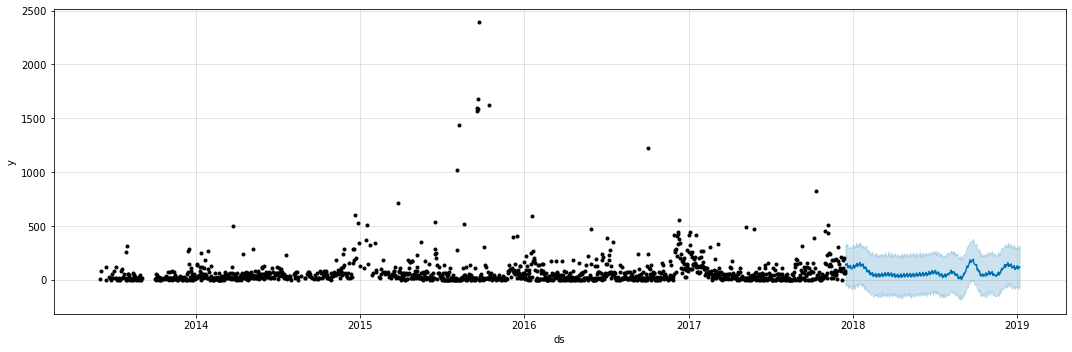

In [26]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

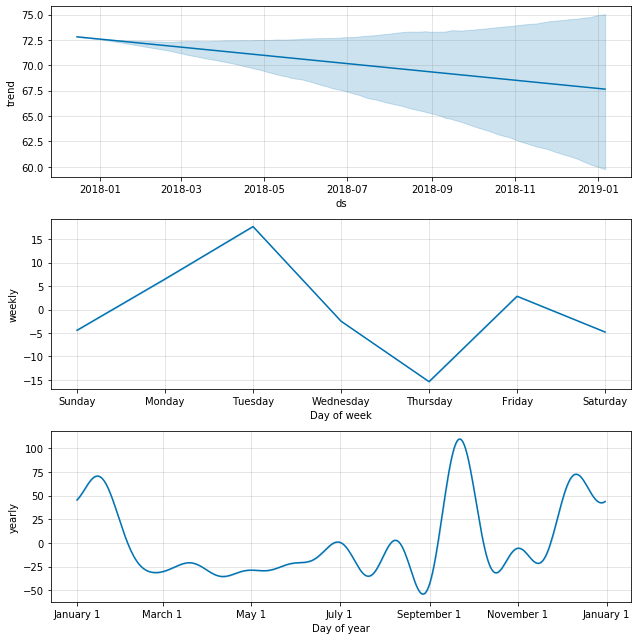

In [27]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

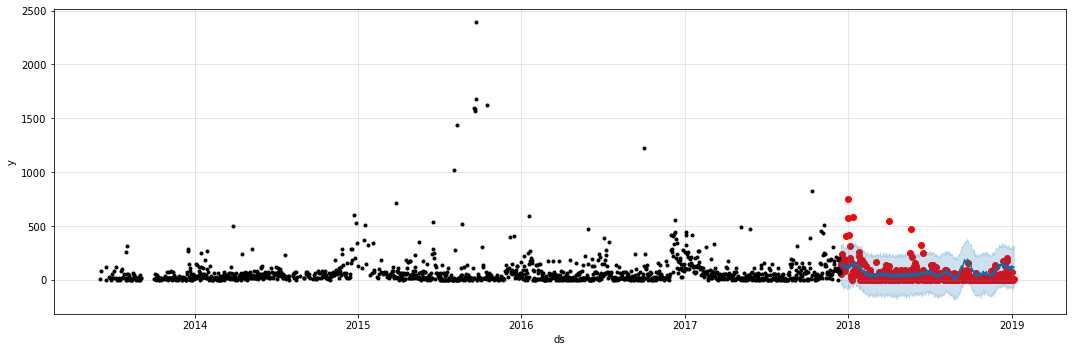

In [31]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['Y'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('11077.csv',index_col=[0],parse_dates=[0])
pjme.drop(["Unnamed: 2","Unnamed: 3","Unnamed: 4"], axis = 1, inplace = True)

In [9]:
pjme.head()

,Y
DS,
2013-06-29,13.0
2013-06-02,5.0
2013-06-04,80.0
2013-06-15,0.0
2013-06-16,120.0


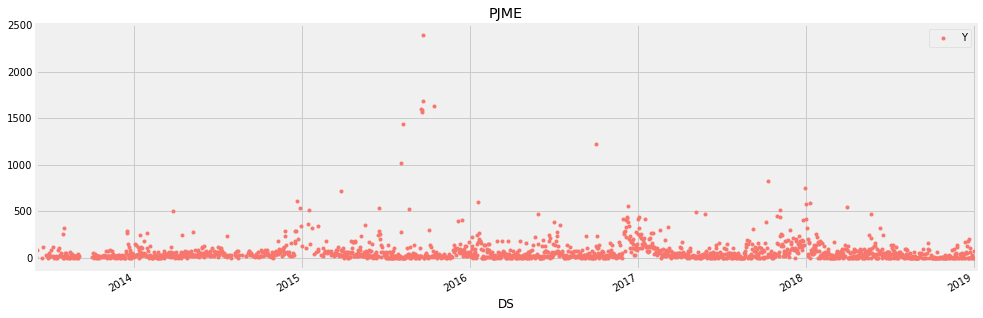

In [6]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJME')
plt.show()

In [7]:
split_date = '14-Dec-2017'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

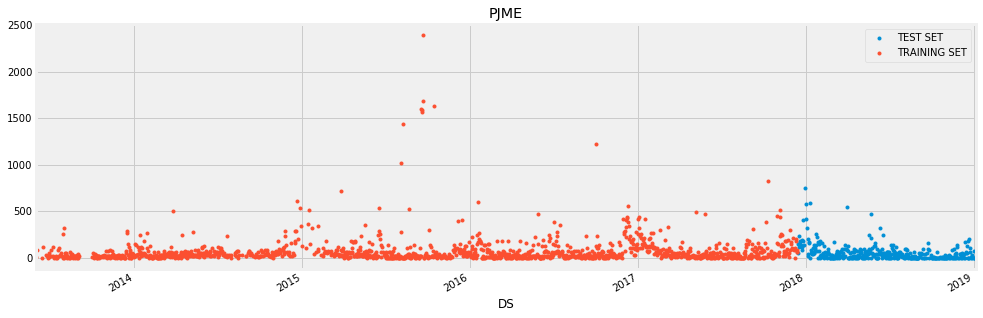

In [10]:
_ = pjme_test \
    .rename(columns={'Y': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Y': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJME', style='.')

In [12]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [13]:
X_train, y_train = create_features(pjme_train, label='Y')
X_test, y_test = create_features(pjme_test, label='Y')

In [17]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DS,,,,,,,,
2013-06-29,0,5,2,6,2013,180,29,26
2013-06-02,0,6,2,6,2013,153,2,22
2013-06-04,0,1,2,6,2013,155,4,23
2013-06-15,0,5,2,6,2013,166,15,24
2013-06-16,0,6,2,6,2013,167,16,24


In [22]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[11:57:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [23]:
_ = plot_importance(reg, height=0.9)

ValueError: Booster.get_score() results in empty

In [24]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

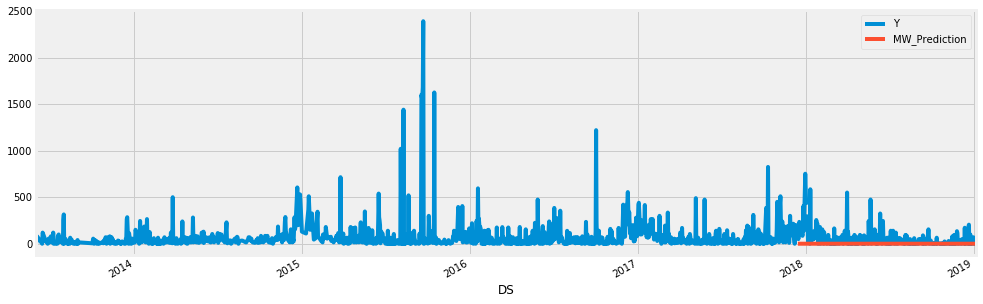

In [25]:
_ = pjme_all[['Y','MW_Prediction']].plot(figsize=(15, 5))

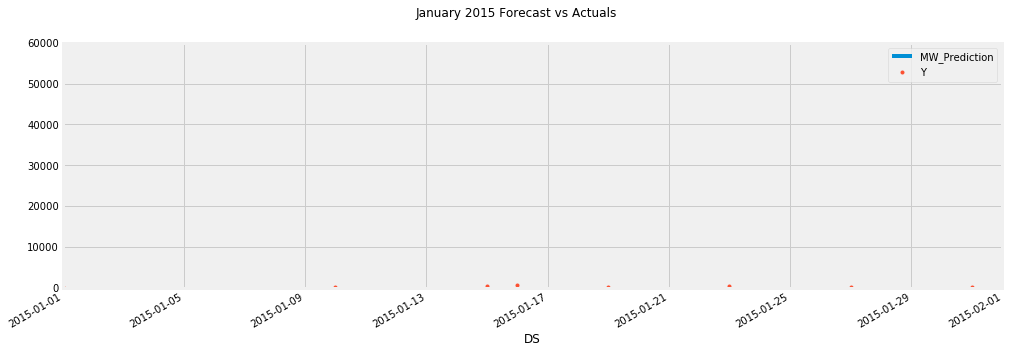

In [27]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','Y']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

In [50]:
y['2017':]

DS
2017-01-01    183.419355
2017-02-01     82.321429
2017-03-01     50.129032
2017-04-01     44.241379
2017-05-01     50.700000
2017-06-01     39.769231
2017-07-01     32.933333
2017-08-01     39.965517
2017-09-01     62.172414
2017-10-01     98.615385
2017-11-01    137.866667
2017-12-01    159.703704
2018-01-01    143.688943
2018-02-01     40.000000
2018-03-01     43.548387
2018-04-01     49.500000
2018-05-01     73.709677
2018-06-01     54.766667
2018-07-01     41.966667
2018-08-01     19.642857
2018-09-01     37.350000
2018-10-01      7.821432
2018-11-01     24.800000
2018-12-01     46.925926
2019-01-01     15.000000
Freq: MS, Name: Y, dtype: float64

TypeError: float() argument must be a string or a number, not 'Period'

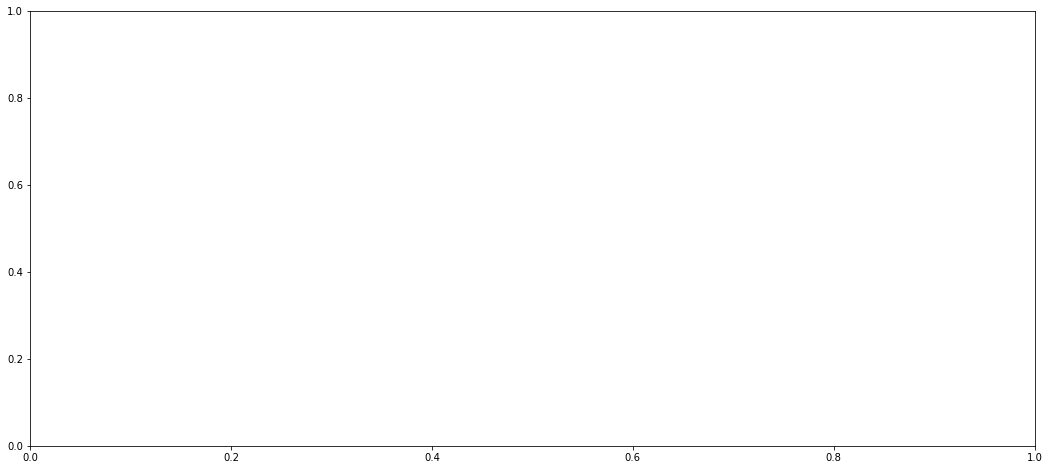

In [55]:
y.plot()

In [53]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None